<a href="https://colab.research.google.com/github/sfonte23/Federal_Piaui/blob/main/f1_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 📁 Importações, Funções e Instalações
---

## Instalações

In [ ]:
!pip install tensorflow

## Importações

In [ ]:
import glob
import os
import shutil
import numpy as np
import uuid
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from typing import Dict,NoReturn
from PIL import Image
from google.colab import drive
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Funções

### Gera um relatório de conteúdo

In [ ]:
def gerar_relatorio_dados(dataset_dir: str) -> Dict[str, Dict[str, int]]:
    """
    Gera e imprime um relatório com a contagem de imagens para cada equipe
    em cada subconjunto (train e val) do diretório do dataset.

    Parâmetros:
        dataset_dir (str): Caminho raiz onde estão os diretórios 'train' e 'val'.

    Retorna:
        dict: Um dicionário com a estrutura {subconjunto: {equipe: quantidade_de_imagens}}.
    """
    relatorio = {}
    for subset in ["train", "val"]:
        subset_path = os.path.join(dataset_dir, subset)
        if not os.path.exists(subset_path):
            print(f"[AVISO] Diretório '{subset_path}' não encontrado.")
            continue

        equipes = os.listdir(subset_path)
        contagem_equipes = {}

        for equipe in equipes:
            equipe_path = os.path.join(subset_path, equipe)
            if not os.path.isdir(equipe_path):
                continue

            imagens = [f for f in os.listdir(equipe_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            contagem_equipes[equipe] = len(imagens)

        relatorio[subset] = contagem_equipes

    # Exibe relatório formatado
    print("=== RELATÓRIO DE IMAGENS ===")
    for subset, equipes in relatorio.items():
        print(f"\nConjunto: {subset.upper()}")
        for equipe, qtd in sorted(equipes.items(), key=lambda x: x[0]):
            print(f" - {equipe}: {qtd} imagens")


### Converter imagens em jpg

In [ ]:
def converter_para_jpg(diretorio: str) -> NoReturn:
    """
    Converte todas as imagens em formatos suportados dentro do diretório (recursivamente)
    para o formato JPEG, removendo os arquivos originais após a conversão.
    Imagens que já estão no formato .jpg são ignoradas.

    Parâmetros:
        diretorio (str): Caminho para o diretório base contendo as imagens a serem convertidas.

    Retorno:
        None: A função atua diretamente nos arquivos e não retorna valor.
    """
    formatos_validos = ['*.webp', '*.jpeg', '*.png', '*.avif']

    for formato in formatos_validos:
        # Busca recursivamente por arquivos no formato atual
        for caminho_img in glob.glob(os.path.join(diretorio, '**', formato), recursive=True):
            try:
                # Ignora arquivos que já estão no formato .jpg (case insensitive)
                if caminho_img.lower().endswith('.jpg'):
                    continue

                # Abre a imagem e converte para RGB para garantir compatibilidade com JPEG
                img = Image.open(caminho_img).convert('RGB')

                # Gera o novo nome do arquivo com extensão .jpg
                novo_nome = os.path.splitext(caminho_img)[0] + '.jpg'

                # Salva a imagem convertida no novo arquivo JPEG
                img.save(novo_nome, 'JPEG')

                # Remove o arquivo original para evitar duplicatas
                os.remove(caminho_img)

            except Exception as e:
                print(f"Erro ao converter {caminho_img}: {e}")


### Alterar nome do arquivo para uuid

In [ ]:
def renomear_imagens(diretorio: str) -> NoReturn:
    """
    Renomeia todas as imagens .jpg em um diretório (e subdiretórios) com nomes únicos usando UUID.

    Parâmetros:
        diretorio (str): Caminho para o diretório onde as imagens devem ser renomeadas.

    Retorno:
        None: A função executa operações diretamente nos arquivos e não retorna valor.
    """
    for raiz, _, arquivos in os.walk(diretorio):
        for nome in arquivos:
            if nome.lower().endswith('.jpg'):
                caminho_antigo = os.path.join(raiz, nome)

                # Gera um nome novo e único para a imagem
                novo_nome = f"{uuid.uuid4()}.jpg"
                caminho_novo = os.path.join(raiz, novo_nome)

                # Renomeia a imagem
                os.rename(caminho_antigo, caminho_novo)


### Excluir arquivos não jpg

In [ ]:
def excluir_nao_jpg(diretorio: str) -> NoReturn:
    """
    Exclui todos os arquivos que não possuem a extensão '.jpg' dentro do diretório
    especificado, incluindo subdiretórios.

    Parâmetros:
        diretorio (str): Caminho do diretório onde a limpeza será realizada.

    Retorno:
        None: A função atua diretamente nos arquivos e não retorna valor.
    """
    for raiz, _, arquivos in os.walk(diretorio):
        for nome in arquivos:
            if not nome.lower().endswith('.jpg'):
                caminho_arquivo = os.path.join(raiz, nome)
                try:
                    os.remove(caminho_arquivo)
                    print(f"Arquivo removido: {caminho_arquivo}")
                except Exception as e:
                    print(f"Erro ao remover {caminho_arquivo}: {e}")


### Funções de Treinamento

In [ ]:
def criar_generators(base_dir: str, img_size: tuple, batch_size: int):
    """
    Cria os geradores de dados para treino e validação com aumentos para treino.
    """
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_gen = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_gen, val_gen

In [ ]:
def criar_modelo(num_classes: int, img_size: tuple):
    """
    Cria o modelo baseado no MobileNetV2 com camadas finais customizadas para classificação.
    """
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
    base_model.trainable = False  # Congela as camadas convolucionais pré-treinadas

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def treinar_modelo(model: Model, train_gen, val_gen, epochs: int, checkpoint_path: str):
    """
    Treina o modelo com callbacks para salvar o melhor modelo e early stopping.
    """
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, earlystop]
    )
    return history

In [ ]:
def plotar_historico(history):
    """
    Plota gráficos de perda e acurácia do treino.
    """
    plt.figure(figsize=(12, 5))

    # Perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Perda durante o treino')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    # Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia durante o treino')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.show()


### Funções de Classificação

In [ ]:
def obter_classes(caminho_classes: Path):
    """Obtém nomes de classes a partir das subpastas de um diretório."""
    classes = [p.name for p in caminho_classes.iterdir() if p.is_dir()]
    classes.sort()  # ordena para manter padrão consistente
    return classes

In [ ]:
def preparar_imagem(caminho_img: Path):
    """Carrega e prepara a imagem para predição."""
    img = load_img(str(caminho_img), target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
def classificar_e_mover(modelo, class_names, caminho_imagem, caminho_saida, mostrar_imagem=True):
    """Classifica a imagem, cria pasta destino e move o arquivo."""
    try:
        if mostrar_imagem:
            img_display = Image.open(caminho_imagem)
            plt.imshow(img_display)
            plt.title(f"Imagem: {caminho_imagem.name}")
            plt.axis('off')
            plt.show()

        img_array = preparar_imagem(caminho_imagem)
        predicao = modelo.predict(img_array)
        indice_classe = np.argmax(predicao)
        nome_classe = class_names[indice_classe]

        pasta_destino = caminho_saida / nome_classe
        pasta_destino.mkdir(parents=True, exist_ok=True)

        destino_final = pasta_destino / caminho_imagem.name

        if destino_final.exists():
            print(f"Arquivo {destino_final} já existe, pulando...")
            return nome_classe  # retorna para imprimir fora a classificação

        shutil.move(str(caminho_imagem), str(destino_final))
        print(f"{caminho_imagem.name} → {nome_classe}")
        return nome_classe
    except Exception as e:
        print(f"Erro ao processar {caminho_imagem.name}: {e}")
        return None


---
# 📂 Extração de Arquivos
---

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Definir diretórios do dataset
base_dir = '/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC'
base_dir_train = '/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/train'
base_dir_val = '/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Gerar relatório de imagens
gerar_relatorio_dados(base_dir)

=== RELATÓRIO DE IMAGENS ===

Conjunto: TRAIN
 - ferrari: 43 imagens
 - mclaren: 33 imagens
 - mercedes: 37 imagens
 - redbull: 30 imagens
 - willians: 33 imagens

Conjunto: VAL
 - ferrari: 17 imagens
 - mclaren: 5 imagens
 - mercedes: 5 imagens
 - redbull: 5 imagens
 - willians: 5 imagens


---
# 🔨 Treinamento de Modelo
---

## 💊 Pré-processamento
Ajustar imagens em um padrão único (jpg) e renomear arquivos uuid4

In [ ]:
# Converter imagens das pastas em padrão único (.jpg)
converter_para_jpg(base_dir_train)
converter_para_jpg(base_dir_val)

# Renomeia Imagens para melhor identificação
renomear_imagens(base_dir_train)
renomear_imagens(base_dir_val)

# Exclui imagens que não sejam .jpg
excluir_nao_jpg(base_dir_train)
excluir_nao_jpg(base_dir_val)

gerar_relatorio_dados(base_dir)

=== RELATÓRIO DE IMAGENS ===

Conjunto: TRAIN
 - ferrari: 43 imagens
 - mclaren: 33 imagens
 - mercedes: 37 imagens
 - redbull: 30 imagens
 - willians: 33 imagens

Conjunto: VAL
 - ferrari: 17 imagens
 - mclaren: 5 imagens
 - mercedes: 5 imagens
 - redbull: 5 imagens
 - willians: 5 imagens


## 💪 Treinamento
Avaliar imagens e treinar modelo para identificar e classificar imagens


Found 176 images belonging to 5 classes.
Found 24 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2613 - loss: 2.0981
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to /content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/modelos_vc/melhor_modelo_f1.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 12s/step - accuracy: 0.2651 - loss: 2.0836 - val_accuracy: 0.4167 - val_loss: 1.4223
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.5346 - loss: 1.1525
Epoch 2: val_accuracy improved from 0.41667 to 0.62500, saving model to /content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/modelos_vc/melhor_modelo_f1.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5408 - loss: 1.1432 - val_accuracy: 0.6250 - val_loss: 1.1952
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.8106 - loss: 0.7471
Epoch 3: val_accuracy improved from 0.62500 to 0.66667, saving model to /content/drive/MyDrive/4º Período/Tópicos Especiais - Vis

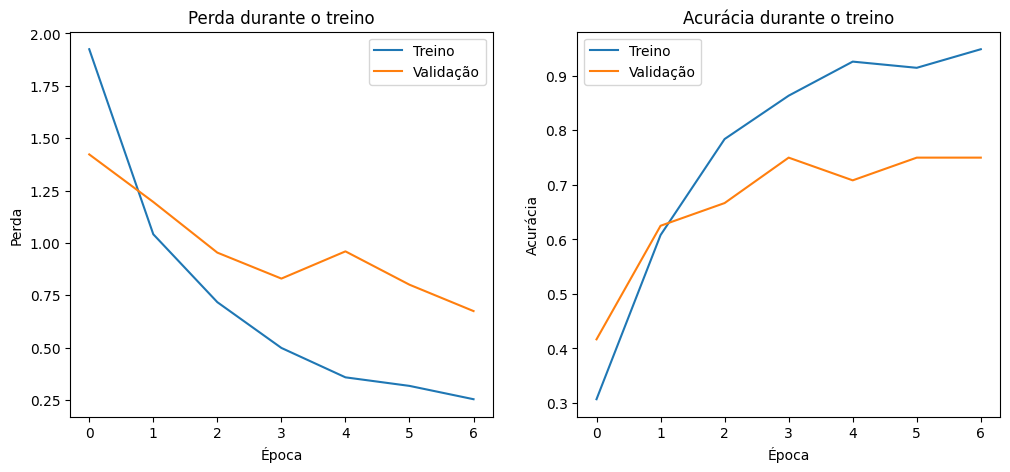

In [ ]:
# Parâmetros
BASE_DIR = base_dir
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

# Criação dos geradores
train_gen, val_gen = criar_generators(BASE_DIR, IMG_SIZE, BATCH_SIZE)

# Número de classes (equipes)
NUM_CLASSES = len(train_gen.class_indices)

# Criação do modelo
model = criar_modelo(NUM_CLASSES, IMG_SIZE)

# Caminho para salvar o melhor modelo
CHECKPOINT_PATH = '/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/modelos_vc/melhor_modelo_f1.keras'

# Treinamento
history = treinar_modelo(model, train_gen, val_gen, EPOCHS, CHECKPOINT_PATH)

# Plotar gráficos do histórico de treino
plotar_historico(history)

**Interpretação do gráfico:**

Perda de treino (linha azul) diminui constantemente, o que indica que o modelo está aprendendo e ajustando bem os dados de treino.

Perda de validação (linha laranja) inicialmente diminui, mas depois oscila e até aumenta em alguns momentos, o que pode indicar que o modelo começa a se ajustar demais aos dados de treino (overfitting).

Acurácia de treino (linha azul) sobe consistentemente, chegando perto de 95%, o que mostra que o modelo está se saindo muito bem no conjunto de treino.

Acurácia de validação (linha laranja) sobe até cerca de 75% e depois estabiliza ou até diminui um pouco, o que indica que a melhoria no conjunto de validação está estagnada e o modelo não está generalizando muito além disso.

**O que isso significa?**

Seu modelo aprendeu bem os dados de treino, mas a generalização para dados novos (validação) parou de melhorar depois da época 4.

Isso indica que, após certo ponto, o modelo começa a memorizar detalhes do conjunto de treino que não ajudam na performance geral (overfitting).

O early stopping foi usado para evitar continuar treinando quando não há melhoria.

---
# 🚀 Hands ON!
---

Classes detectadas: ['ferrari', 'mclaren', 'mercedes', 'redbull', 'willians']


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Modelo carregado com sucesso.
Total de imagens para classificar: 1
Imagens encontradas: ['Captura de tela 2025-05-14 213201.png']


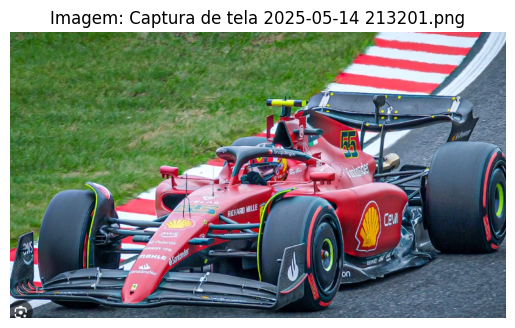

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Captura de tela 2025-05-14 213201.png → ferrari
Imagem 'Captura de tela 2025-05-14 213201.png' classificada como 'ferrari'


In [ ]:
# Caminhos
CAMINHO_MODELO = Path('/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/modelos_vc/modelo_f1.keras')
CAMINHO_NOVAS = Path('/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/novas_imagens')
CAMINHO_SAIDA = Path('/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/imagens_classificadas')
CAMINHO_CLASSES = Path('/content/drive/MyDrive/4º Período/Tópicos Especiais - Visão Computacional/Projeto - VC/val')

# Parâmetros do modelo
IMG_SIZE = (224, 224)  # ajuste aqui se usar outro tamanho
EXTENSOES_VALIDAS = {'.jpg', '.jpeg', '.png', '.webp'}

# Carrega classes automaticamente
class_names = obter_classes(CAMINHO_CLASSES)
print(f"Classes detectadas: {class_names}")

# Carrega modelo
modelo = load_model(str(CAMINHO_MODELO))
print("Modelo carregado com sucesso.")

# Filtra as imagens válidas
imagens_validas = [f for f in CAMINHO_NOVAS.iterdir() if f.suffix.lower() in EXTENSOES_VALIDAS]
print(f"Total de imagens para classificar: {len(imagens_validas)}")
print("Imagens encontradas:", [img.name for img in imagens_validas])

# Processa imagens novas
for arquivo in imagens_validas:
    classificacao = classificar_e_mover(modelo, class_names, arquivo, CAMINHO_SAIDA, mostrar_imagem=True)
    if classificacao is not None:
        print(f"Imagem '{arquivo.name}' classificada como '{classificacao}'")